In [1]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Dropout
import pywt
from tqdm.notebook import tqdm
from skimage.transform import resize
from collections import Counter

In [3]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='data/PAMAP2_Dataset/Protocol/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

In [4]:
data = load_subjects()

In [5]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029207,109


As we can see we have NaN in our data, so we need to change their value. We will take every NaN value and eplace it with the mean value of the column.
Also, we can note from the map that acitvity_id = 0 is not an valid activity

In [6]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [7]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
2928,37.66,1,107.487925,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1.000000,0.000000,0.000000,0.000000,101
2929,37.67,1,107.487925,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1.000000,0.000000,0.000000,0.000000,101
2930,37.68,1,107.487925,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1.000000,0.000000,0.000000,0.000000,101
2931,37.69,1,107.487925,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1.000000,0.000000,0.000000,0.000000,101
2932,37.70,1,100.000000,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872015,95.06,24,162.000000,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109
2872016,95.07,24,162.000000,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,0.003629,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,109
2872017,95.08,24,162.000000,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,109
2872018,95.09,24,162.000000,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,109


In [9]:
from sklearn.preprocessing import MinMaxScaler

def split_train_test(data):
    # create the test data
    subject107 = data[data['id'] == 107]
    subject108 = data[data['id'] == 108]
    test = subject107.append(subject108)

    # create the train data
    train = data[data['id'] != 107]
    train = data[data['id'] != 108]

    # drop the columns id and time
    test = test.drop(["id"], axis=1)
    train = train.drop(["id"], axis=1)

    # split train and test to X and y
    X_train = train.drop(['activity_id','time_stamp'], axis=1).values
    X_test = test.drop(['activity_id','time_stamp'], axis=1).values
    
    # make data scale to min max beetwin 0 to 1
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_train)
    min_max_scaler.fit(X_test)
    X_train = min_max_scaler.transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    
    y_train = train['activity_id'].values
    y_test = test['activity_id'].values
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(data)
print('Train shape X :',X_train.shape,' y ', y_train.shape)
print('Test shape X :',X_test.shape,' y ', y_test.shape)

Train shape X : (1680770, 52)  y  (1680770,)
Test shape X : (494878, 52)  y  (494878,)


In [10]:
def window(a, w, o, copy = False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view

In [31]:
window(X_train[:,51],w=256,o=128)

array([[0.49495535, 0.49495535, 0.49495535, ..., 0.49495535, 0.49495535,
        0.49495535],
       [0.49495535, 0.49495535, 0.49495535, ..., 0.49495535, 0.49495535,
        0.49495535],
       [0.49495535, 0.49495535, 0.49495535, ..., 0.49495535, 0.49495535,
        0.49495535],
       ...,
       [0.31469158, 0.30942043, 0.30346669, ..., 0.30162766, 0.29388961,
        0.28656675],
       [0.45030589, 0.44480453, 0.43998699, ..., 0.27664725, 0.27515007,
        0.27371777],
       [0.28077605, 0.27671269, 0.27627549, ..., 0.28135202, 0.28146371,
        0.28167018]])

In [40]:
w=256
o=128
f = 52

shape_train = window(X_train[:,0],w=w,o=o).shape
X_train_roll = np.ndarray(shape=(shape_train[0],shape_train[1],f))

shape_test = window(X_test[:,0],w=w,o=o).shape
X_test_roll = np.ndarray(shape=(shape_test[0],shape_test[1],f))

for i in tqdm(range(f)):
    X_train_roll[:,:,i] = window(X_train[:,i],w=256,o=128)
    X_test_roll[:,:,i] = window(X_test[:,i],w=256,o=128)

  0%|          | 0/52 [00:00<?, ?it/s]

In [101]:
y_train_new = []
for i in tqdm(window(y_train,w=256,o=128)):
    value = Counter(i).most_common(1)[0][0]
    y_train_new.append(value)
y_train_new = np.array(y_train_new)
y_train_new.shape

  0%|          | 0/13130 [00:00<?, ?it/s]

(13130,)

In [102]:
y_test_new = []
for i in tqdm(window(y_test,w=256,o=128)):
    value = Counter(i).most_common(1)[0][0]
    y_test_new.append(value)
y_test_new = np.array(y_test_new)
y_test_new.shape

  0%|          | 0/3865 [00:00<?, ?it/s]

(3865,)

In [100]:
y_new.shape

(13130,)

In [68]:
np.save("data/PAMAP2_Dataset/Preprcessed/X_train_roll.npy", X_train_roll)
np.save("data/PAMAP2_Dataset/Preprcessed/X_test_roll.npy", X_test_roll)

In [105]:
np.save("data/PAMAP2_Dataset/Preprcessed/y_train_roll.npy", y_train_new)
np.save("data/PAMAP2_Dataset/Preprcessed/y_test_roll.npy", y_test_new)

In [59]:
x0 = X_train_roll[1000,:,20]
x0.shape

scales = np.arange(1, 64)
coeffs, freqs = pywt.cwt(x0, scales, wavelet = 'morl')

No handles with labels found to put in legend.


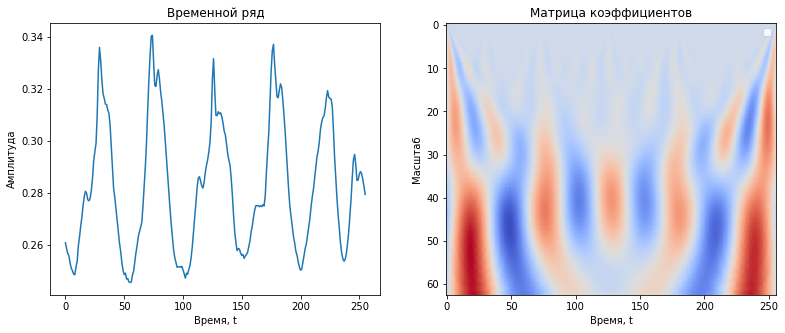

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,5))
ax1.plot(x0)
ax1.set_title('Временной ряд')
ax1.set_ylabel('Амплитуда')
ax1.set_xlabel('Время, t')
ax2.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
ax2.set_title('Матрица коэффициентов')
ax2.set_ylabel('Масштаб')
ax2.set_xlabel('Время, t')
plt.legend()
plt.show()

In [70]:
def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in tqdm(range(n_samples)):
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt
  
# amount of pixels in X and Y 
rescale_size = 32
# determine the max scale size
n_scales = 32

X_train_cwt = create_cwt_images(X_train_roll, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test_roll, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

  0%|          | 0/13130 [00:00<?, ?it/s]

shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (13130, 32, 32, 52)


  0%|          | 0/3865 [00:00<?, ?it/s]

shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: (3865, 32, 32, 52)


In [71]:
np.save("data/PAMAP2_Dataset/Preprcessed/X_train_cwt.npy", X_train_cwt)
np.save("data/PAMAP2_Dataset/Preprcessed/X_test_cwt.npy", X_test_cwt)

In [66]:
#loaded_array = np.load("data/PAMAP2_Dataset/Preprcessed/X_train_cwt.npy")